In [1]:
from segment import CustomSegmentor
from ensemble import TeacherGuidedSegmentation
from ultralytics import YOLO
import argparse
import os
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
image_folder = "./samples"
yolo_path = "./food-seg-modified/yolov8x-seg-modified/weights/last.pt"
sam_type = "vit_h"
sam_checkpoint_path = "./sam_vit_h_4b8939.pth"
save_path = "./sample_out"

In [3]:
# Load YOLO Model
yolo = YOLO(yolo_path)

In [4]:
# Load Custom Color List (RGB format; for visualization)
custom_color_list = np.load("./color_list.npy")
custom_color_list[:5]

array([[120, 120, 120],
       [180, 120, 120],
       [  6, 230, 230],
       [ 80,  50,  50],
       [  4, 200,   3]])

In [5]:
sample_img_paths = sorted(glob(image_folder + "/*.jpg"))
sample_img_paths

['./samples/087195.jpg',
 './samples/118926.jpg',
 './samples/181794.jpg',
 './samples/182237.jpg',
 './samples/185711.jpg']

In [6]:
# Run Pipeline for sample images
for sample_img_path in tqdm(sample_img_paths):
    sample_img_path = sample_img_path.replace("\\", "/")    # for windows
    img_no = sample_img_path.split("/")[-1].split(".")[0]
    save_folder_path = os.path.join(save_path, img_no)
    
    custom_segmentor = CustomSegmentor(sample_img_path, save_folder_path)    # SAM initialize
    custom_segmentor.sam_segmentation()   # SAM inference
    
    shutil.copy(sample_img_path, save_folder_path) # copy the original image
    
    org_w, org_h = Image.open(sample_img_path).size    # get original image size

    yolo_results = yolo(sample_img_path, verbose=False)    # YOLO inference
    assert len(yolo_results[0].boxes) == len(yolo_results[0].masks.data)

    if not yolo_results[0].masks:  # no segmentation
        continue

    # define segmentation color index (label)
    seg_color_idx = (
        yolo_results[0].boxes.cls
        if yolo_results[0].boxes
        else range(len(yolo_results[0].masks.data))
    ).detach().cpu().numpy().astype(np.int16)

    # load segmentation colors based on color index
    seg_colors = [tuple(custom_color_list[x]) for x in seg_color_idx]

    # get YOLO masks
    yolo_masks = yolo_results[0].masks.data
    
    if len(yolo_masks) > 1:
        detected_classes = yolo_results[0].boxes.cls.detach().cpu().tolist()
        cls_masks = np.zeros(yolo_results[0].masks[0].data.shape, dtype=np.int16)
        for i in range(len(yolo_results[0].masks)):
            cls_mask = yolo_results[0].masks[i].data.detach().cpu().numpy()
            cls_mask[cls_mask == 1] = int(detected_classes[i])
            cls_masks[cls_masks == 0] = cls_mask[cls_masks == 0]
    else:
        detected_class = yolo_results[0].boxes.cls.detach().cpu().tolist()[0]
        cls_masks = yolo_results[0].masks[0].data.detach().cpu().numpy().astype(np.int16)
        cls_masks[cls_masks == 1] = int(detected_class)
        
    cls_masks = cls_masks.squeeze(axis=0)
    cls_masks = cv2.resize(cls_masks, (org_w, org_h))
    np.save(os.path.join(save_folder_path, "yolo_mask.npy"), cls_masks)

    custom_segmentor.yolo_segmentation(yolo_masks, seg_colors)
    
    custom_ensembler = TeacherGuidedSegmentation(save_folder_path, sample_img_path)
    
    ensembled_masks = custom_ensembler.ensemble_segmentation()
    custom_ensembler.visualization_save(ensembled_masks, custom_color_list)

  0%|          | 0/5 [00:00<?, ?it/s]

./sample_out/087195/sam_mask/0 assigned label: [ 0, background, 0.93, 0.1979 ]
./sample_out/087195/sam_mask/1 assigned label: [ 27, shrimp_prawn, 1.00, 0.0061 ]
./sample_out/087195/sam_mask/2 assigned label: [ 27, shrimp_prawn, 1.00, 0.0039 ]
./sample_out/087195/sam_mask/3 assigned label: [ 79, salad_leaf_salad_green, 0.99, 0.0074 ]
./sample_out/087195/sam_mask/4 assigned label: [ 27, shrimp_prawn, 1.00, 0.0093 ]
./sample_out/087195/sam_mask/5 assigned label: [ 27, shrimp_prawn, 1.00, 0.0153 ]
./sample_out/087195/sam_mask/6 assigned label: [ 27, shrimp_prawn, 1.00, 0.0085 ]
./sample_out/087195/sam_mask/7 assigned label: [ 27, shrimp_prawn, 0.93, 0.0083 ]
./sample_out/087195/sam_mask/8 assigned label: [ 27, shrimp_prawn, 0.87, 0.0082 ]
./sample_out/087195/sam_mask/9 assigned label: [ 27, shrimp_prawn, 1.00, 0.0167 ]
./sample_out/087195/sam_mask/10 assigned label: [ 79, salad_leaf_salad_green, 0.77, 0.0130 ]
./sample_out/087195/sam_mask/11 assigned label: [ 79, salad_leaf_salad_green, 0.

In [7]:
def visualization(path: str) -> None:
    img_id = path.split("/")[-1]
    org_img_path = os.path.join(path, f"{img_id}.jpg")
    yolo_seg_path = os.path.join(path, "yolo_vis.png")
    ensembled_seg_path = os.path.join(path, "ensembled_vis.png")
    org_img = cv2.imread(org_img_path)
    yolo_seg_img = cv2.imread(yolo_seg_path)
    ensembled_seg_img = cv2.imread(ensembled_seg_path)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10), tight_layout=True)

    axs[0].imshow(plt.imread(org_img_path))
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(yolo_seg_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("YOLO")
    axs[1].axis("off")
    
    axs[2].imshow(cv2.cvtColor(ensembled_seg_img, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Teacher-Guided")
    axs[2].axis("off")
    plt.suptitle(f"{img_id}.jpg", fontsize=16, y=0.7)  

    plt.show()

In [8]:
folder_nums = os.listdir("./sample_out")
folder_nums

['087195', '118926', '181794', '182237', '185711']

In [9]:
folder_paths = []
for folder_num in folder_nums:
    folder_path = f"./sample_out/{folder_num}"
    folder_paths.append(folder_path)
    print(folder_path)

./sample_out/087195
./sample_out/118926
./sample_out/181794
./sample_out/182237
./sample_out/185711


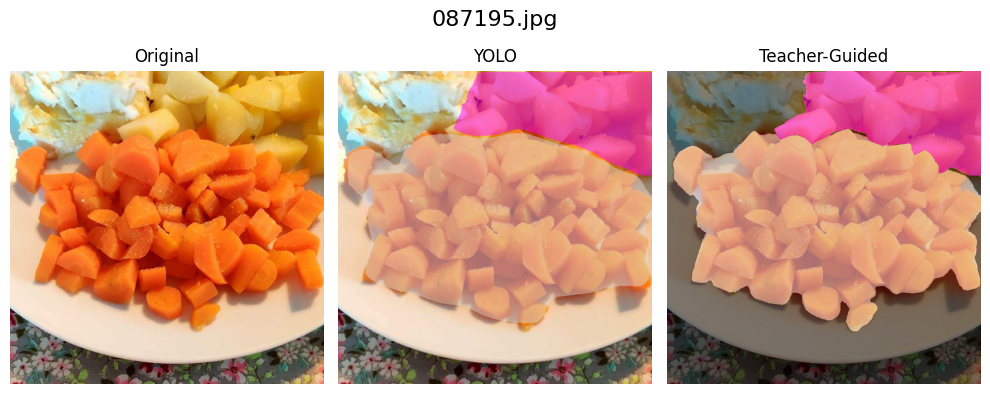

In [10]:
visualization(folder_paths[0])

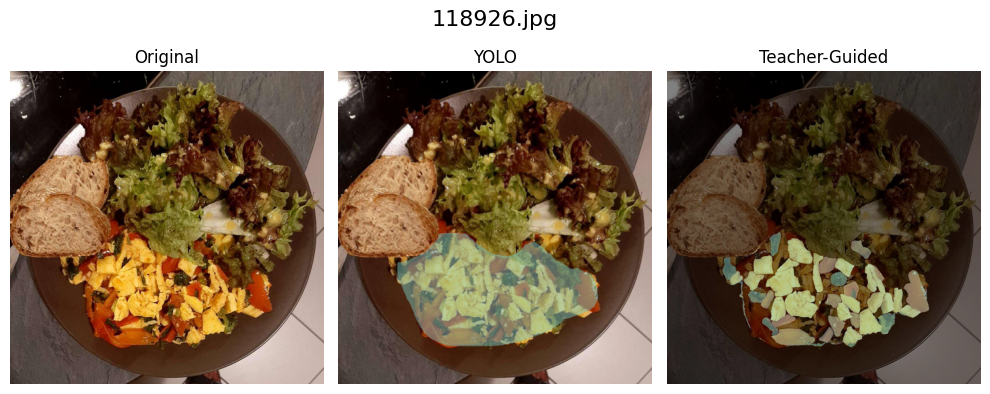

In [11]:
visualization(folder_paths[1])

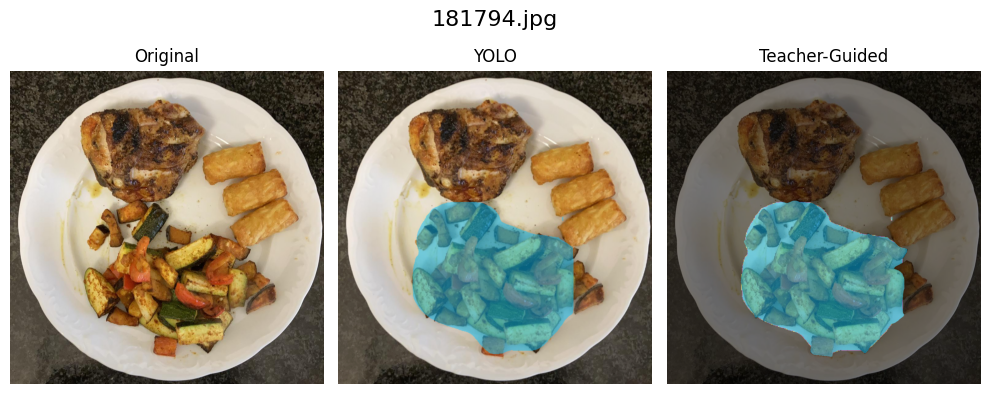

In [12]:
visualization(folder_paths[2])

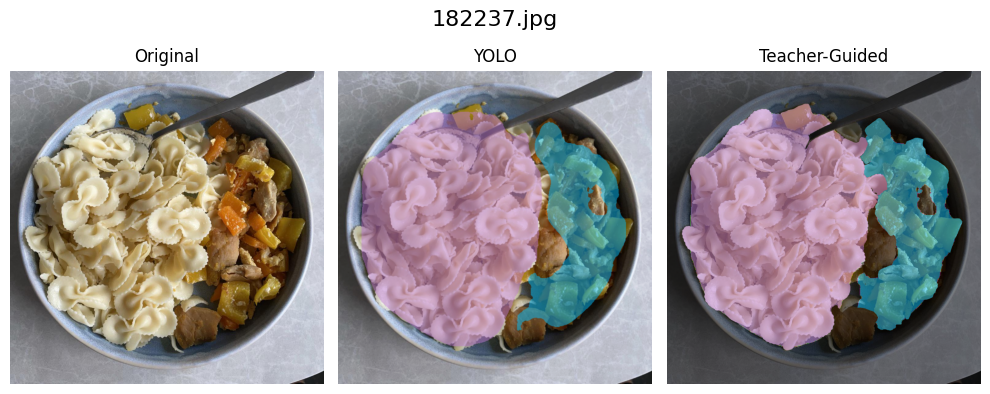

In [13]:
visualization(folder_paths[3])

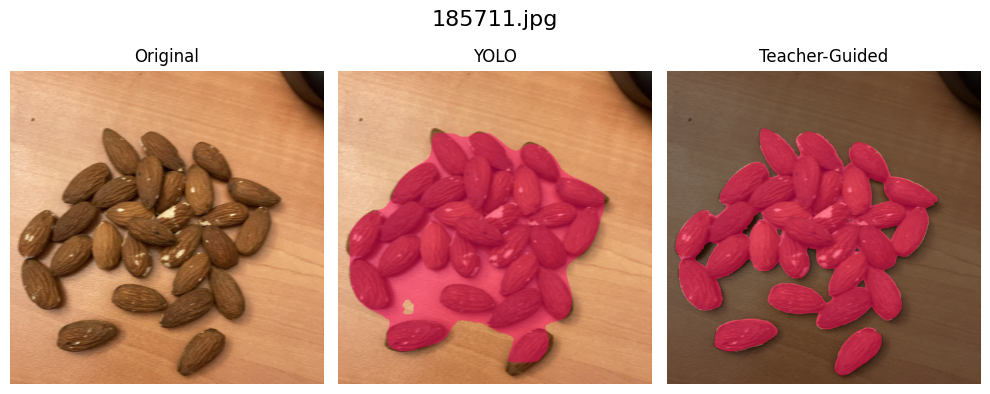

In [14]:
visualization(folder_paths[4])